In [1]:
import chardet
import os
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD   
from nltk.tokenize import word_tokenize
import nltk
from fuzzywuzzy import fuzz
import random
import time
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer

/Users/wally/anaconda3/envs/3350/lib/python3.11/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# 1. Data Importing and Cleaning

In [2]:
def detect_encoding(file_path):
    with open(file_path, 'rb') as file:
        raw_data = file.read()

    result = chardet.detect(raw_data)
    return result['encoding']

def srt_to_text(srt_file_path):
    encoding_attempts = ['utf-8', 'ISO-8859-1', 'utf-16', ]

    for encoding in encoding_attempts:
        try:
            with open(srt_file_path, 'r', encoding=encoding) as file:
                lines = file.readlines()

            text = ""
            current_line = ""
            is_time_line = True

            for line in lines:
                line = line.strip()

                if not line:
                    is_time_line = True
                    continue

                if is_time_line:
                    is_time_line = False
                    continue

                current_line += line + " "

                # If the line ends with a punctuation indicating the end of a sentence
                if line.endswith(('.', '!', '?')):
                    text += current_line + "\n"
                    current_line = ""

            return text.strip()
        except UnicodeDecodeError:
            None

    # If none of the encodings work
    print(f"Unable to decode file: {srt_file_path}")
    return None

def process_srt_files_in_folder(folder_path):
    result_dict = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".srt"):
            srt_file_path = os.path.join(folder_path, filename)
            text_content = srt_to_text(srt_file_path)

            if text_content is not None:
                file_dict = {"name": filename, "text": text_content}
                result_dict.append(file_dict)

    return result_dict

# Example usage for a folder containing SRT files
wally = '/Users/wally/Library/CloudStorage/OneDrive-Personal/Documents/Cornell/1. Fourth Year/INFO 6350 - Text Mining History and Literature/INFO6350_Final_Project/srt_files'
casey = '/Users/caseykaufman/Documents/GitHub/INFO6350_Final_Project/srt_files'

folder_path = wally

result_dictionary = process_srt_files_in_folder(folder_path)

In [3]:
movie_subtitles_df = pd.DataFrame(result_dictionary)

In [4]:
# Removal of timestamps
movie_subtitles_df['text'] = movie_subtitles_df['text'].str.replace(r'\d{2}:\d{2}:\d{2},\d{3} --> \d{2}:\d{2}:\d{2},\d{3}[\s-]+', '\n', regex=True)
movie_subtitles_df['text'] = movie_subtitles_df['text'].str.replace(r'<font.*?>|<\/font>', '', regex=True)
movie_subtitles_df['text'] = movie_subtitles_df['text'].str.replace(r'\bdownloaded.*?|subtitles downloaded.*?|http.*?|www.*?', '', regex=True, flags=re.IGNORECASE)

In [5]:
pd.options.display.max_rows = 400

In [6]:
# Find the year of each movie from the file name
years = []
for name_index in range(len(movie_subtitles_df['name'])):
    found_year = False
    for letter_index in range(len(movie_subtitles_df['name'][name_index])):
        if movie_subtitles_df['name'][name_index][letter_index:letter_index+2] == '19' and movie_subtitles_df['name'][name_index][letter_index:letter_index+4].isdigit() or movie_subtitles_df['name'][name_index][letter_index:letter_index+2] == '20' and movie_subtitles_df['name'][name_index][letter_index:letter_index+4].isdigit():
            y = movie_subtitles_df['name'][name_index][letter_index:letter_index+4]
            years.append(y)
            found_year = True
            break
    if not found_year:
        years.append('na')

# Add new column with corresponding years
movie_subtitles_df['years'] = years

In [7]:
#cleaning names
pattern1= r'^([^\d(]+)(?:\.\d{4}| \(\d{4}\))?\.?[^\w]*'
pattern2 = r'^[^a-zA-Z]*(.*?)\.[a-zA-Z]{3}\b'
pattern3 = r'^[^a-zA-Z]*(.*?)\.[a-zA-Z]{3}-'

clean_names = []
for file_name in movie_subtitles_df['name']:
    match = re.match(pattern1, file_name) or re.match(pattern2, file_name) or re.match(pattern3, file_name)
    if match:
        extracted_name = match.group(1).replace('.', ' ')
        clean_names.append(extracted_name)
    else:
        print("Name extraction pattern not found for:", file_name)
        
new = [name.split('WWW')[0].strip() if 'WWW' in name else name for name in clean_names]
clean_names = [x.replace('-','') for x in new]

In [8]:
movie_subtitles_df['Movie Name'] = clean_names

In [9]:
#adding win/loss
excel = pd.read_csv('scripts.csv')

#getting index values
highest = []
for films in clean_names: 
    similarity = []
    indexes = []
    for all_films in excel['Film']:
        sim = fuzz.ratio(str(films), str(all_films))
        similarity.append(sim)
    highest.append(similarity.index(max(similarity)))
    
movie_name_check = []
win_loss = []
for idx in highest:
    value1 = excel.loc[idx,'Film']
    value2 = excel.loc[idx,'Win']
    movie_name_check.append(value1)
    win_loss.append(value2)
    
movie_subtitles_df['Similarity Calc Name'] = movie_name_check
movie_subtitles_df['Win or Loss'] = win_loss

In [10]:
movie_subtitles_df.head()

,name,text,years,Movie Name,Similarity Calc Name,Win or Loss
0,Sunset Blvd. (1950)_english.srt,"\nYes, this is Sunset Boulevard, Los Angeles, ...",1950,Sunset Blvd,Sunset Boulevard,1.0
1,Diner.1982.720p.BluRay.x264-AMIABLE.srt,\nA little bit softer now - Shout \nA little b...,1982,Diner,Diner,0.0
2,Road.To.Utopia.1945.1080p.BluRay.x264-[YTS.AM]...,"\nFor those of you who don't go to the movies,...",1945,Road To Utopia,Road to Utopia,0.0
3,Tender Mercies (1983).srt,"\nHere, give me the bottle. \n- Go to hell. \n...",1983,Tender Mercies,Tender Mercies,1.0
4,Ghandi.1982.1080p.BluRay.x264.YIFY.srt,\nThere are more than yesterday. \n\nHe will b...,1982,Ghandi,Gandhi,1.0


In [11]:
# Tokenize the text in each row
tokenized_text = movie_subtitles_df['text'].apply(word_tokenize)

# Add the tokenized text to a new column
movie_subtitles_df['tokenized_text'] = tokenized_text

# 2. Basic Data Exploration and Pre-Processing

## Count Tokens in Each Movie Script

In [12]:
# Add the number of tokens in a movie script to a new column titled 'num_tokens'
movie_subtitles_df['num_tokens'] = [len(movie_subtitles_df['tokenized_text'][i]) for i in range(len(movie_subtitles_df['text']))]

In [13]:
movie_subtitles_df.head()

,name,text,years,Movie Name,Similarity Calc Name,Win or Loss,tokenized_text,num_tokens
0,Sunset Blvd. (1950)_english.srt,"\nYes, this is Sunset Boulevard, Los Angeles, ...",1950,Sunset Blvd,Sunset Boulevard,1.0,"[Yes, ,, this, is, Sunset, Boulevard, ,, Los, ...",15458
1,Diner.1982.720p.BluRay.x264-AMIABLE.srt,\nA little bit softer now - Shout \nA little b...,1982,Diner,Diner,0.0,"[A, little, bit, softer, now, -, Shout, A, lit...",16868
2,Road.To.Utopia.1945.1080p.BluRay.x264-[YTS.AM]...,"\nFor those of you who don't go to the movies,...",1945,Road To Utopia,Road to Utopia,0.0,"[For, those, of, you, who, do, n't, go, to, th...",15171
3,Tender Mercies (1983).srt,"\nHere, give me the bottle. \n- Go to hell. \n...",1983,Tender Mercies,Tender Mercies,1.0,"[Here, ,, give, me, the, bottle, ., -, Go, to,...",9986
4,Ghandi.1982.1080p.BluRay.x264.YIFY.srt,\nThere are more than yesterday. \n\nHe will b...,1982,Ghandi,Gandhi,1.0,"[There, are, more, than, yesterday, ., He, wil...",15581


#### Most Frequently Occurring Tokens

In [14]:
token_lists = movie_subtitles_df['tokenized_text']

# Flatten the list of lists into a single list of tokens
all_tokens = [token for sublist in token_lists for token in sublist]

# Use Counter to count the occurrences of each token
token_counts = Counter(all_tokens)

# Get the 50 most common tokens
top_50_tokens = token_counts.most_common(50)

# Display the result
print("Top 50 most frequent tokens:")
for token, count in top_50_tokens:
    print(f"{token}: {count}")

Top 50 most frequent tokens:
.: 414286
,: 232214
I: 141293
?: 116160
you: 115244
the: 92202
to: 78841
's: 73480
a: 69298
n't: 53126
>: 52743
<: 52724
-: 51210
it: 48673
...: 48166
!: 46899
of: 40656
You: 38629
that: 38238
do: 37603
and: 37378
in: 35179
me: 31524
is: 30225
i: 26309
/i: 25798
on: 24445
'm: 23886
for: 23345
're: 21855
have: 21703
know: 21232
your: 20688
be: 20360
What: 20156
this: 20117
It: 19824
was: 19415
my: 18844
we: 18309
with: 17123
not: 17103
are: 16685
'll: 16383
he: 15184
what: 15001
all: 14702
No: 13869
like: 13832
right: 13581


#### Number of Tokens by Year

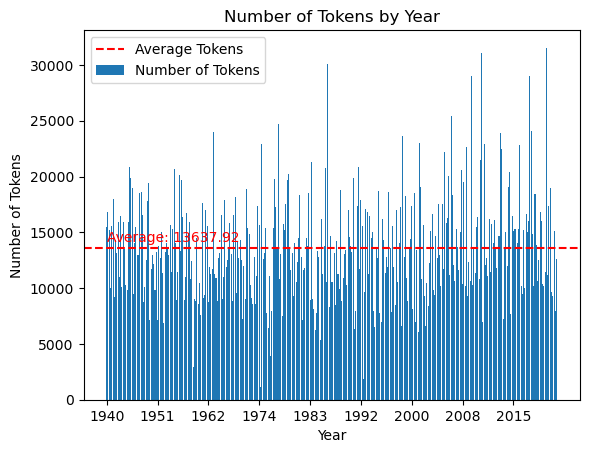

In [15]:
import matplotlib.pyplot as plt

# Sort DataFrame by 'years' in ascending order
movie_subtitles_df = movie_subtitles_df.sort_values(by='years')

# Set x-axis ticks to show only once every other 20 years
step = 40  # Adjust the step value as needed
plt.xticks(range(0, len(movie_subtitles_df['years']), step), movie_subtitles_df['years'][::step])

# Create bar chart
plt.bar(movie_subtitles_df.index, movie_subtitles_df['num_tokens'], label='Number of Tokens')
plt.xlabel('Year')
plt.ylabel('Number of Tokens')
plt.title('Number of Tokens by Year')

# Plot the average line
average_tokens = movie_subtitles_df['num_tokens'].mean()
plt.axhline(y=average_tokens, color='red', linestyle='--', label='Average Tokens')

# Display the average value
plt.text(0.5, average_tokens + 500, f'Average: {average_tokens:.2f}', color='red', ha='left')

plt.legend()
plt.show()

#### Minimum number of tokens vs maximum number of tokens

Minimum number of tokens in all scripts:  1125
Maximum number of tokens in all scripts:  31547


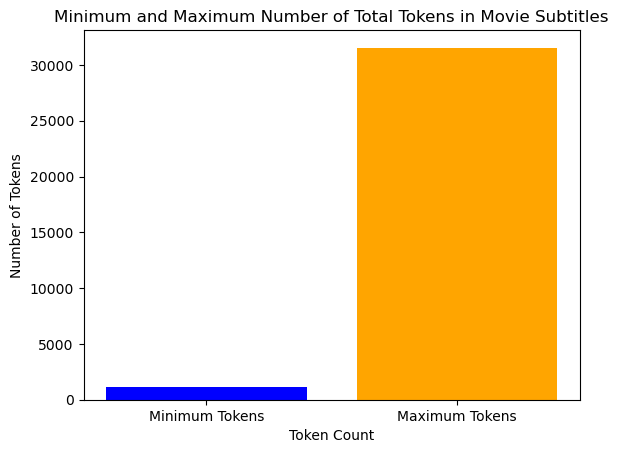

In [16]:
# Minimum number of tokens versus maximum number of tokens
min_tokens = min(movie_subtitles_df['num_tokens'])
max_tokens = max(movie_subtitles_df['num_tokens'])

print('Minimum number of tokens in all scripts: ', min_tokens)
print('Maximum number of tokens in all scripts: ', max_tokens)

# Plotting the data
labels = ['Minimum Tokens', 'Maximum Tokens']
values = [min_tokens, max_tokens]

plt.bar(labels, values, color=['blue', 'orange'])
plt.xlabel('Token Count')
plt.ylabel('Number of Tokens')
plt.title('Minimum and Maximum Number of Total Tokens in Movie Subtitles')
plt.show()

#### Longest paragraph/line versus shortest paragraph/line, split on line breaks

Longest Paragraph length: 
284

Shortest Paragraph length: 
2


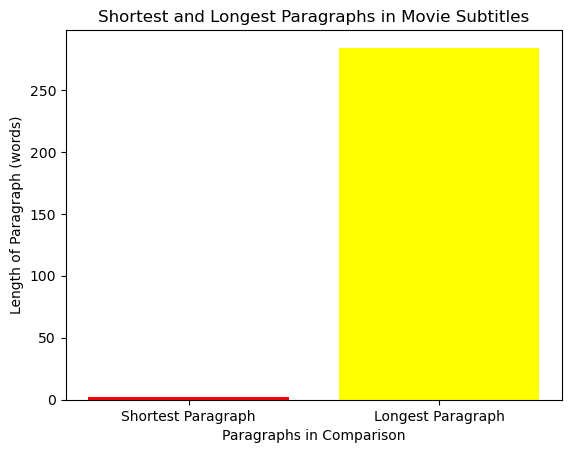

In [17]:
# Find the longest and shortest paragraphs
max_length = 0
min_length = 100000000
longest_paragraph = ''
shortest_paragraph = ''

for index, row in movie_subtitles_df.iterrows():
    paragraphs = row['text'].split('\n')  # Assuming paragraphs are separated by '\n'
    
    for paragraph in paragraphs:
        paragraph_length = len(paragraph)
        
        # Update longest paragraph
        if paragraph_length > max_length:
            max_length = paragraph_length
            longest_paragraph = paragraph

        # Update shortest paragraph
        if paragraph_length < min_length and paragraph.strip():  # Check for non-empty paragraphs
            min_length = paragraph_length
            shortest_paragraph = paragraph

print("Longest Paragraph length: ")
print(len(longest_paragraph))

print("\nShortest Paragraph length: ")
print(len(shortest_paragraph))

# Plotting the data
labels = ['Shortest Paragraph', 'Longest Paragraph']
values = [len(shortest_paragraph), len(longest_paragraph)]

plt.bar(labels, values, color=['red', 'yellow'])
plt.xlabel('Paragraphs in Comparison')
plt.ylabel('Length of Paragraph (words)')
plt.title('Shortest and Longest Paragraphs in Movie Subtitles')
plt.show()

#### See Cosine Similarity Scores Between Movies

We were curious to see how similar movie subtitle scripts are to each other in general using cosine similarity scoring, first with stop words, then without stop words.

In [18]:
# Create a TF-IDF vectorizer to conduct similarity test with stop word removal
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(movie_subtitles_df['text'])

# Compute cosine similarity between movies
similarity_matrix = cosine_similarity(tfidf_matrix)

# Print the average similarity scores
print("Average Cosine Similarity Score Without Removing Stopwords: ")
print(np.mean(similarity_matrix))

Average Cosine Similarity Score Without Removing Stopwords: 
0.6701699398505467


In [19]:
# Create a TF-IDF vectorizer to conduct similarity test with stop word removal
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(movie_subtitles_df['text'])

# Compute cosine similarity between movies
similarity_matrix = cosine_similarity(tfidf_matrix)

# Print the average similarity scores
print("Average Cosine Similarity Score, Removing Stopwords: ")
print(np.mean(similarity_matrix))

Average Cosine Similarity Score, Removing Stopwords: 
0.17171533811168818


It appears that when stop words are not removed, movie subtitles are quite similar, scoring .67 in cosine similarity. This seems logical, as subtitles are largely dialogue, and there are frequently occurring pieces of speech in all dialogue. When stop words are removed, the average cosine similarity score drops to .17, which is also logical. This leads us to believe that during classification tasks, models might find it difficult to differentiate between winners and losers of the Academy Award for Best Original Screenplay based on tokens if stop words are not removed, since it appears that there is significant similarity between subtitles.

#### Visualizing the 700 most frequently occurring token unigrams between winners and losers, using truncated SVD

In [20]:
# Vectorizer to get token unigram counts
vectorizer = TfidfVectorizer(max_features=700, stop_words='english')
X = vectorizer.fit_transform(movie_subtitles_df['text'])

# Convert the matrix to DataFrame
features = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Set features and labels
labels = movie_subtitles_df['Win or Loss']
features = features  # No length normalization

# Display the shapes of features and labels
print('Features Shape:', features.shape, 'Labels Shape:', labels.shape)

Features Shape: (355, 700) Labels Shape: (355,)


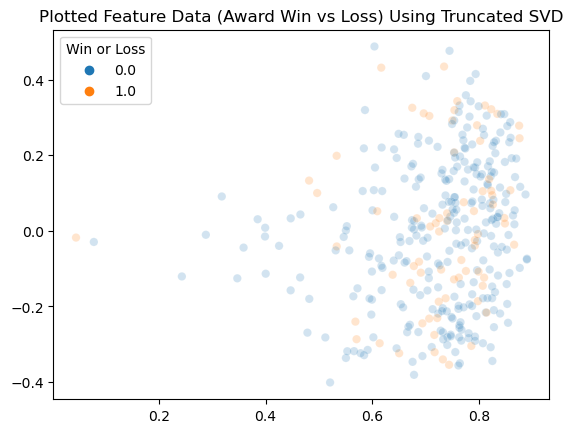

In [21]:
# Plot the feature data, default: 2 dimensional truncated SVD
features_reduced = TruncatedSVD().fit_transform(features)
sns.scatterplot(x=features_reduced[:,0], y=features_reduced[:,1], hue=labels, alpha=0.2)
plt.title('Plotted Feature Data (Award Win vs Loss) Using Truncated SVD')
plt.show()

## Create Chunks of Tokens out of the Paragraphs

Since there is a significant discrepancy between the lengths of the shortest "paragraph" and the longest "paragraph", we felt like creating standardized chunks of tokens to feed into our vectorizer could help normalize our vectors and provide more informative outputs.

In [22]:
def generate_chunks(paragraphs, movie, year, win_loss, chunk_size=200):
    chunks = []
    chunk_movie_name = []
    chunk_year = []
    chunk_win_loss = []

    for i in range(len(paragraphs)):
        text = paragraphs.iloc[i]  # Extract the text from the Series
        newsletter_type = movie.iloc[i]
        date = year.iloc[i]
        result = win_loss.iloc[i]

        # Split the text into paragraphs using '\n'
        text_paragraphs = text.split('\n')

        current_chunk = []
        current_chunk_movie_name = []
        current_chunk_win_loss = []

        for paragraph in text_paragraphs:
            # Check if the length of the paragraph exceeds the chunk size
            if len(paragraph) > chunk_size:
                chunks.append(paragraph)
                chunk_movie_name.append(newsletter_type)
                chunk_year.append(date)
                chunk_win_loss.append(result)
            else:
                # If not, add the paragraph to the current chunk
                current_chunk.append(paragraph)
                current_chunk_movie_name.append(newsletter_type)
                current_chunk_win_loss.append(result)

                # Check if the current chunk size exceeds the specified limit
                if len(' '.join(current_chunk)) > chunk_size:
                    chunks.append(' '.join(current_chunk))
                    chunk_year.extend([date])
                    chunk_movie_name.append(newsletter_type)
                    chunk_win_loss.append(result)
                    current_chunk = []
                    current_chunk_movie_name = []
                    current_chunk_win_loss = []

        # Add any remaining paragraphs to the last chunk
        if current_chunk:
            chunks.append(' '.join(current_chunk))
            chunk_year.extend([date])
            chunk_movie_name.append(newsletter_type)
            chunk_win_loss.append(result)

    return chunks, chunk_movie_name, chunk_year, chunk_win_loss

# Generate chunks
text_chunks, chunk_movie_name, chunk_year, chunk_win_loss = generate_chunks(
    movie_subtitles_df['text'],
    movie_subtitles_df['Similarity Calc Name'],
    movie_subtitles_df['years'],
    movie_subtitles_df['Win or Loss']
)


In [23]:
# Visualize token chunk features
chunks_df = pd.DataFrame({
    'Text Chunk': text_chunks,
    'Movie Name': chunk_movie_name,
    'Year': chunk_year,
    'Win or Loss': chunk_win_loss
})

chunks_df

,Text Chunk,Movie Name,Year,Win or Loss
0,What's new? - Same old daily bunkeroo. Mr....,Foreign Correspondent,1940,0.0
1,Bah! Foreign correspondent! I could get mo...,Foreign Correspondent,1940,0.0
2,is a daily guessing game. I want some facts...,Foreign Correspondent,1940,0.0
3,You've written a book on economics or somethi...,Foreign Correspondent,1940,0.0
4,"I want a reporter, somebody who doesn't know ...",Foreign Correspondent,1940,0.0
...,...,...,...,...
90449,"<i>What you mean?</i> <i>Nein, nein, nein...<...",Triangle of Sadness,2022,0.0
90450,Abigail! - Yaya! Yaya! Abigail! Abigai...,Triangle of Sadness,2022,0.0
90451,"It's been there the whole fucking time, Abiga...",Triangle of Sadness,2022,0.0
90452,- Ah... Sorry. Let's go. I need to wee-w...,Triangle of Sadness,2022,0.0


In [24]:
# TFIDF Vectorizer with idf on
chunk_vectorizer = TfidfVectorizer(use_idf=True, norm=None)

In [25]:
# Vectorize chunked texts
X_chunked = chunk_vectorizer.fit_transform(text_chunks)

# 3. Unsupervised Cluster Analysis

An initial unsupervised cluster analysis was performed to identify any discernible patterns in the data prior to further processing. Potential areas of pattern appearance are hypothesized to potentially be: winners/losers, movie release time period, and differences in sentiment.

First, we used the elbow method to try and identify the optimal number of clusters for which to perform the KMeans cluster analysis. For each value of K, we are calculating WCSS (Within-Cluster Sum of Square). WCSS is the sum of the squared distance between each point and the centroid in a cluster.

In [26]:
# # Using the elbow method to find the optimal number of clusters
# # Referenced: https://www.analyticsvidhya.com/blog/2021/01/in-depth-intuition-of-k-means-clustering-algorithm-in-machine-learning/

# wcss = [] 
# t0 = time.time()
# for i in range(1, 20): 
#     kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
#     kmeans.fit(X_chunked) 
#     wcss.append(kmeans.inertia_)
# t1 = time.time()
    
# print("Plotting the Elbow curve took:{:.1f}s ".format(t1-t0))

# # Plotting the Elbow Curve
# plt.figure(figsize=(8, 6))
# plt.plot(range(1, 20), wcss, marker='o', linestyle='-', color='b')
# plt.title('Elbow Method for Optimal K')
# plt.xlabel('Number of Clusters (K)')
# plt.ylabel('Within-Cluster-Sum-of-Squares (WCSS)')
# plt.show()

In [27]:
# y_pred = KMeans(n_clusters=2, n_init='auto').fit_predict(X_chunked)

In [28]:
# # Plotting function
# def plot_compare(X, labels, title, alpha=0.2):
#     '''
#     Takes an array of object data, a list of cluster labels, a title string, and an optional alpha value.
#     Reduces dimensions to 2 if necessary and plots the clustering with and without coloring by label.
#     Returns nothing.
#     '''
#     if X.shape[1] > 2:
#         svd = TruncatedSVD(n_components=3)
#         X_2d = svd.fit_transform(X)
#     else:
#         X_2d = X

#     # initialize figsize in prompt
#     plt.figure(figsize=(12, 6))

#     # left subplot, alpha value in function cell
#     plt.subplot(121)
#     plt.scatter(X_2d[:, 0], X_2d[:, 1], alpha=alpha)
#     plt.title("Dimension-Reduced Unclustered Data")

#     # right subplot, same coordinate data and supplied cluster labels, alpha value in function cell
#     plt.subplot(122)
#     plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, alpha=alpha)
#     plt.title("Data with Clustering")

#     # Set the common title for the entire figure
#     plt.title(title)

In [29]:
# # plot resulting clustering
# plot_compare(X_chunked, y_pred, 'k-Means Clustering with 3 Groups on Vectorized Movie Data')

Since the Within-Cluster-Sum-of-Squares (WCSS) does not seem to show a clear elbow during the KMeans analysis, we realized that KMeans might not be the best algorithm to try and determine patterns or clusters in the data. Since there is no distinct elbow, interpretation is also much less straightforward. Therefore, it is difficult to try to support or reject the hypotheses set out at the onset of the KMeans analysis. 

# 4. Baseline Supervised Classification Task for Winner vs Loser Classification 

We aimed to apply two commonly used supervised classification methods (Logistic Regression and Random Forest) in 3 slightly modified methods (unigram token features, 200 token chunk features, stopword removal) to set a baseline understanding of whether classifying movies into winner or loser categories for the Academy Awards Best Original Screenplay was possible, and attempt to understand that of the 3 methods, which performed the best what we could learn from their performance.

## I. Using Top 100 Unigram Token Features

#### Identifying the top 100 features
Referenced PS2 method - performed a feature reduction, selectng the top 100 features using a random forest selector to reduce the number of features fed into the model - this was to help address dimentionality issues that could have arisen.

In [30]:
# Create a Vectorizer
vectorizer = TfidfVectorizer(use_idf=True)
X = vectorizer.fit_transform(movie_subtitles_df['text'])

# Convert the TF-IDF matrix to a DataFrame
features = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Set features and labels
labels = movie_subtitles_df['Win or Loss']
features = features

# Display the shapes of features and labels
print('Features Shape:', features.shape, 'Labels Shape:', labels.shape)

Features Shape: (355, 53266) Labels Shape: (355,)


In [31]:
# Train the model on the full feature set
rf_full = RandomForestClassifier()
rf_full.fit(features, labels)

# Get feature importances
importances = rf_full.feature_importances_
indices = importances.argsort()[::-1]

# Select the top 100 features
top_100_features_rf = np.array(vectorizer.get_feature_names_out())[indices][:100]
print("Top 100 features (Random Forest):", top_100_features_rf)

Top 100 features (Random Forest): ['choking' 'wichita' 'care' 'daughter' 'glory' 'currency' 'man'
 'straightening' 'regretted' 'gallons' 'mr' 'listen' 'psycho' 'wagon'
 'angeles' 'table' 'worryin' 'busy' 'them' 'goin' 'contestants' 'named'
 'wilson' 'max' 'coffee' 'deal' 'precedence' 'illiterate' 'after'
 'chopping' 'cops' 'sew' 'talk' 'honor' 'customary' 'snowball' 'quack'
 'banks' 'gal' 'drop' 'debts' 'shack' 'clings' 'bailing' 'inclined'
 'tried' 'gotta' 'insanity' 'gold' 'stalk' 'paper' 'stillwater' 'dean'
 'meatballs' 'mcdonald' 'takin' 'watchin' 'apparatus' 'transactions'
 'colour' 'honestly' 'silver' 'lessons' 'dickens' 'why' 'studying' 'lower'
 'bury' '7500' 'presume' 'simple' 'processed' 'hiya' 'reduced' 'assuredly'
 'yale' 'quaint' 'stinkin' 'redondo' 'lot' 'schoolteacher' 'metro' 'haze'
 'weird' 'at' 'announced' 'month' 'wretched' 'when' 'directly' 'lettin'
 'bay' 'raised' 'contact' 'part' 'acres' 'dieu' 'assumption' 'clean'
 'sing']


In [32]:
X_top_100 = features[top_100_features_rf]
y = labels

### Logistic Regression

In [33]:
# Train test val split
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X_top_100, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.5, random_state=42)

# Extract NumPy arrays from DataFrames
X_train_array = X_train.values
X_val_array = X_val.values
X_test_array = X_test.values

In [34]:
# Train logistic regression model on data
logreg_clf = LogisticRegression(max_iter=10000).fit(X_train_array, y_train)

# Predict on the validation data
y_val_pred = logreg_clf.predict(X_val_array)
print(classification_report(y_val, y_val_pred, zero_division = 1))

              precision    recall  f1-score   support

         0.0       0.81      1.00      0.89       100
         1.0       1.00      0.00      0.00        24

    accuracy                           0.81       124
   macro avg       0.90      0.50      0.45       124
weighted avg       0.84      0.81      0.72       124



In [35]:
# Predict on test set
y_test_pred = logreg_clf.predict(X_test_array)
print(classification_report(y_test, y_test_pred, zero_division = 1))

              precision    recall  f1-score   support

         0.0       0.80      1.00      0.89        86
         1.0       1.00      0.00      0.00        21

    accuracy                           0.80       107
   macro avg       0.90      0.50      0.45       107
weighted avg       0.84      0.80      0.72       107



### Random Forest

In [36]:
# Train random forest  classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_array, y_train)

RandomForestClassifier(random_state=42)

In [37]:
# Predict on validation set
rf_val_predictions = rf_clf.predict(X_val_array)
print(classification_report(y_val, rf_val_predictions, zero_division=1))

              precision    recall  f1-score   support

         0.0       0.82      0.99      0.90       100
         1.0       0.67      0.08      0.15        24

    accuracy                           0.81       124
   macro avg       0.74      0.54      0.52       124
weighted avg       0.79      0.81      0.75       124



In [38]:
# Predict on test set
rf_test_predictions = rf_clf.predict(X_test_array)
print(classification_report(y_test, rf_test_predictions, zero_division=1))

              precision    recall  f1-score   support

         0.0       0.80      0.99      0.89        86
         1.0       0.00      0.00      1.00        21

    accuracy                           0.79       107
   macro avg       0.40      0.49      0.94       107
weighted avg       0.64      0.79      0.91       107



## II. Using Token Chunk Features

#### Pre-processing and creating train test split

In [39]:
X = text_chunks
y = chunk_win_loss

In [40]:
# Train test val Split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

I set a 70%, 15%, 15% split for training, test, and validation sets, respectively. I also introduced stratification of the datasets to maintain the distribution of classes in each subset.

In [41]:
baseline_classification_vectorizer = TfidfVectorizer(use_idf=True, norm=None)

In [42]:
X_train_transformed = baseline_classification_vectorizer.fit_transform(X_train)
X_test_transformed = baseline_classification_vectorizer.transform(X_test)
X_val_transformed = baseline_classification_vectorizer.transform(X_val)

### Logistic Regression

In [43]:
# Train logistic regression classifier
logreg_clf = LogisticRegression(max_iter = 10000).fit(X_train_transformed, y_train)

In [44]:
# Predict on validation set
logreg_val_predictions = logreg_clf.predict(X_val_transformed)
print(classification_report(y_val, logreg_val_predictions, zero_division=1))

              precision    recall  f1-score   support

         0.0       0.87      0.87      0.87     10720
         1.0       0.52      0.53      0.52      2848

    accuracy                           0.80     13568
   macro avg       0.70      0.70      0.70     13568
weighted avg       0.80      0.80      0.80     13568



In [45]:
# Predict on test set
logreg_test_predictions = logreg_clf.predict(X_test_transformed)
print(classification_report(y_test, logreg_test_predictions, zero_division=1))

              precision    recall  f1-score   support

         0.0       0.88      0.86      0.87     10720
         1.0       0.51      0.54      0.53      2849

    accuracy                           0.80     13569
   macro avg       0.69      0.70      0.70     13569
weighted avg       0.80      0.80      0.80     13569



It seems as though the logistic regression classifier is essentially predicting that all movie scripts will lose and not win the Academy Award for Best Original Screenplay. 

### Random Forest

In [46]:
# Train random forest  classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_transformed, y_train)

RandomForestClassifier(random_state=42)

In [47]:
# Predict on validation set
rf_val_predictions = rf_clf.predict(X_val_transformed)
print(classification_report(y_val, rf_val_predictions, zero_division=1))

              precision    recall  f1-score   support

         0.0       0.84      0.99      0.91     10720
         1.0       0.88      0.27      0.42      2848

    accuracy                           0.84     13568
   macro avg       0.86      0.63      0.66     13568
weighted avg       0.85      0.84      0.80     13568



In [48]:
# Predict on test set
rf_test_predictions = rf_clf.predict(X_test_transformed)
print(classification_report(y_test, rf_test_predictions, zero_division=1))

              precision    recall  f1-score   support

         0.0       0.84      0.99      0.91     10720
         1.0       0.89      0.28      0.43      2849

    accuracy                           0.84     13569
   macro avg       0.86      0.64      0.67     13569
weighted avg       0.85      0.84      0.81     13569



## III. Same as Part 5, but with Stopword Removal

In [49]:
# Create vectorizer with stop word removal
stopword_removal_classification_vectorizer = TfidfVectorizer(use_idf=True, stop_words = 'english')

In [50]:
X_train_transformed = stopword_removal_classification_vectorizer.fit_transform(X_train)
X_test_transformed = stopword_removal_classification_vectorizer.transform(X_test)
X_val_transformed = stopword_removal_classification_vectorizer.transform(X_val)

### Logistic Regression

In [51]:
# Train logistic regression classifier
logreg_clf = LogisticRegression(max_iter = 10000).fit(X_train_transformed, y_train)

In [52]:
# Predict on validation set
logreg_val_predictions = logreg_clf.predict(X_val_transformed)
print(classification_report(y_val, logreg_val_predictions, zero_division=1))

              precision    recall  f1-score   support

         0.0       0.82      0.99      0.90     10720
         1.0       0.89      0.20      0.33      2848

    accuracy                           0.83     13568
   macro avg       0.86      0.60      0.61     13568
weighted avg       0.84      0.83      0.78     13568



In [53]:
# Predict on test set
logreg_test_predictions = logreg_clf.predict(X_test_transformed)
print(classification_report(y_test, logreg_test_predictions, zero_division=1))

              precision    recall  f1-score   support

         0.0       0.82      0.99      0.90     10720
         1.0       0.90      0.20      0.33      2849

    accuracy                           0.83     13569
   macro avg       0.86      0.60      0.61     13569
weighted avg       0.84      0.83      0.78     13569



### Random Forest

In [54]:
# Train random forest  classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_transformed, y_train)

RandomForestClassifier(random_state=42)

In [55]:
# Predict on validation set
rf_val_predictions = rf_clf.predict(X_val_transformed)
print(classification_report(y_val, rf_val_predictions, zero_division=1))

              precision    recall  f1-score   support

         0.0       0.85      0.99      0.91     10720
         1.0       0.86      0.32      0.47      2848

    accuracy                           0.85     13568
   macro avg       0.85      0.65      0.69     13568
weighted avg       0.85      0.85      0.82     13568



In [56]:
# Predict on test set
rf_test_predictions = rf_clf.predict(X_test_transformed)
print(classification_report(y_test, rf_test_predictions, zero_division=1))

              precision    recall  f1-score   support

         0.0       0.85      0.98      0.91     10720
         1.0       0.85      0.34      0.49      2849

    accuracy                           0.85     13569
   macro avg       0.85      0.66      0.70     13569
weighted avg       0.85      0.85      0.82     13569



## Section Summary

In all 3 sections, we kept it consistent with a TFIDF vectorizer with IDF turned on. All in all though, it seems that random forest performs better than logistic regression on average, 200 token chunk features result in better predictions than token unigrams, and as hypothesized earlier, removal of stopwords also aids in accuracy of prediction. These results could possibly indicate the importance of context, as 200-word chunks may better preserve the semantic context of the text compared to isolated token unigrams. By grouping words together, chunks might capture more meaningful phrases and expressions, providing richer contextual information for classification. At the same time, chunks can help mitigate the downsides of feature sparsity, which can be a negative when inputting full texts as features. Overall, the baseline tests are very effective at predicting win/loss of a movie.

(also, not shown here, but prior to running classification using token chunks as features, we used entire movie subtitles as features, and saw worse performance, with weighted average scores hovering around 0.7 for both logistic regression and random forest classifiers)

# 5. Baseline Supervised Classification Task for Decade Classification

In [71]:
#decades 
# twenties = movie_subtitles_df[(movie_subtitles_df['Year'] >= '1920') & (movie_subtitles_df['Year'] < '1930')]
# thirties = movie_subtitles_df[(movie_subtitles_df['Year'] >= '1930') & (movie_subtitles_df['Year'] < '1940')]
forties = movie_subtitles_df[(movie_subtitles_df['years'] >= '1940') & (movie_subtitles_df['years'] < '1950')]
fifties = movie_subtitles_df[(movie_subtitles_df['years'] >= '1950') & (movie_subtitles_df['years'] < '1960')]
sixties = movie_subtitles_df[(movie_subtitles_df['years'] >= '1960') & (movie_subtitles_df['years'] < '1970')]
seventies = movie_subtitles_df[(movie_subtitles_df['years'] >= '1970') & (movie_subtitles_df['years'] < '1980')]
eighties = movie_subtitles_df[(movie_subtitles_df['years'] >= '1980') & (movie_subtitles_df['years'] < '1990')]
ninties = movie_subtitles_df[(movie_subtitles_df['years'] >= '1990') & (movie_subtitles_df['years'] < '2000')]
twenty = movie_subtitles_df[(movie_subtitles_df['years'] >= '2000') & (movie_subtitles_df['years'] < '2010')]
twenty_ten = movie_subtitles_df[(movie_subtitles_df['years'] >= '2010') & (movie_subtitles_df['years'] < '2020')]

In [83]:
# Assign labels to each decade using .loc
forties.loc[:, 'decade'] = '1940s'
fifties.loc[:, 'decade'] = '1950s'
sixties.loc[:, 'decade'] = '1960s'
seventies.loc[:, 'decade'] = '1970s'
eighties.loc[:, 'decade'] = '1980s'
ninties.loc[:, 'decade'] = '1990s'
twenty.loc[:, 'decade'] = '2000s'
twenty_ten.loc[:, 'decade'] = '2010s'

# Concatenate the DataFrames
decades = pd.concat([forties, fifties, sixties, seventies, eighties, ninties, twenty, twenty_ten])


# Concatenate the DataFrames
decades = pd.concat([forties, fifties, sixties, seventies, eighties, ninties, twenty, twenty_ten])

# Generate chunks
text_chunks, chunk_movie_name, chunk_decades, chunk_win_loss = generate_chunks(
    decades['text'],
    decades['Similarity Calc Name'],
    decades['decade'],
    decades['Win or Loss']
)

# Features
X = stopword_removal_classification_vectorizer.fit_transform(text_chunks)
y = chunk_decades

In [89]:
# Train test val Split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [90]:
# Train the random forest classifier
rf_clf.fit(X_train, y_train)

# Predict on the test set
rf_decade_pred = rf_clf.predict(X_test)

# Print the classification report
print(classification_report(y_test, rf_decade_pred, zero_division=1))

              precision    recall  f1-score   support

       1940s       0.45      0.46      0.46      1327
       1950s       0.45      0.38      0.41      1358
       1960s       0.65      0.26      0.37       971
       1970s       0.47      0.31      0.37      1498
       1980s       0.37      0.40      0.38      1783
       1990s       0.37      0.51      0.43      2084
       2000s       0.47      0.32      0.38      1778
       2010s       0.43      0.60      0.50      2150

    accuracy                           0.42     12949
   macro avg       0.46      0.41      0.41     12949
weighted avg       0.44      0.42      0.42     12949



In [91]:
# Train the logistic regression classifier
logreg_clf.fit(X_train, y_train)

# Predict on the test set
logreg_decade_pred = logreg_clf.predict(X_test)

# Print the classification report
print(classification_report(y_test, logreg_decade_pred, zero_division=1))

              precision    recall  f1-score   support

       1940s       0.58      0.58      0.58      1327
       1950s       0.56      0.55      0.56      1358
       1960s       0.64      0.37      0.47       971
       1970s       0.54      0.44      0.48      1498
       1980s       0.50      0.49      0.49      1783
       1990s       0.49      0.58      0.53      2084
       2000s       0.54      0.50      0.52      1778
       2010s       0.55      0.66      0.60      2150

    accuracy                           0.54     12949
   macro avg       0.55      0.52      0.53     12949
weighted avg       0.54      0.54      0.53     12949



KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x160ce2d40> (for post_execute):


KeyboardInterrupt: 

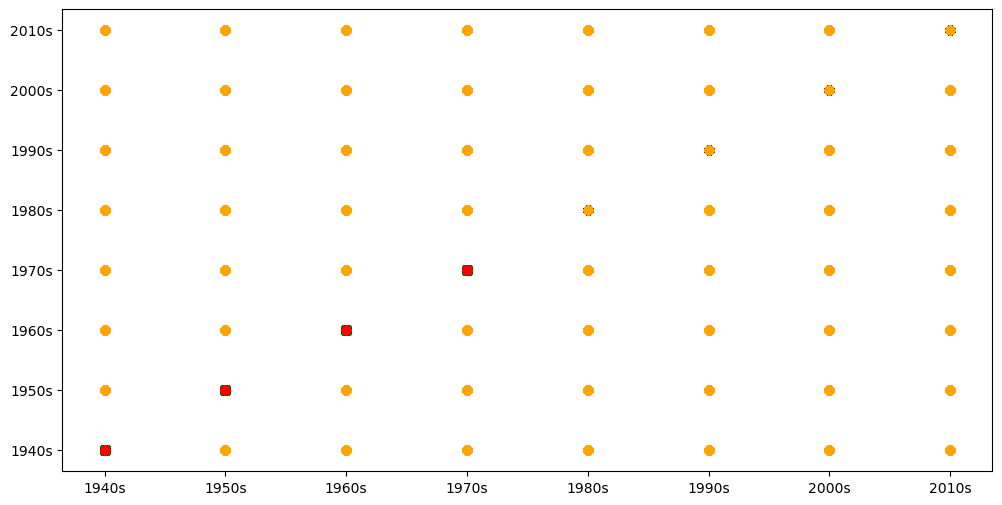

In [106]:
# Prediction on whole set of tokens for visualization purposes
logreg_decade_pred = logreg_clf.predict(X)

year_pred_df = pd.DataFrame({
    'text': text_chunks,
    'movie_name': chunk_movie_name,
    'decade': chunk_decades,
    'win_loss': chunk_win_loss,
    'logreg_decade_pred': logreg_decade_pred
})

year_pred_df['decade'] = year_pred_df['decade'].astype(str)

year_pred_df = year_pred_df.sort_values(by='decade')

# # Plotting
# plt.figure(figsize=(12, 6))

# # Plotting actual labels
# plt.scatter(year_pred_df['decade'], year_pred_df['decade'], label='Actual Labels', alpha=0.7, color='blue')

# # Plotting predicted labels
# plt.scatter(year_pred_df['decade'], year_pred_df['logreg_decade_pred'], label='Predicted Labels', alpha=0.7, color='orange')

# # Highlight win/loss status
# for i, win_loss in enumerate(year_pred_df['win_loss']):
#     color = 'green' if win_loss == 1 else 'red'
#     plt.scatter(year_pred_df['decade'].iloc[i], year_pred_df['decade'].iloc[i],
#                 label=None, alpha=0.7, color=color, marker='x' if win_loss == 1 else 'o')

# plt.title('Actual vs Predicted Labels Over Time with Win/Loss Status')
# plt.xlabel('Decade')
# plt.ylabel('Label')
# plt.legend()
# plt.show()

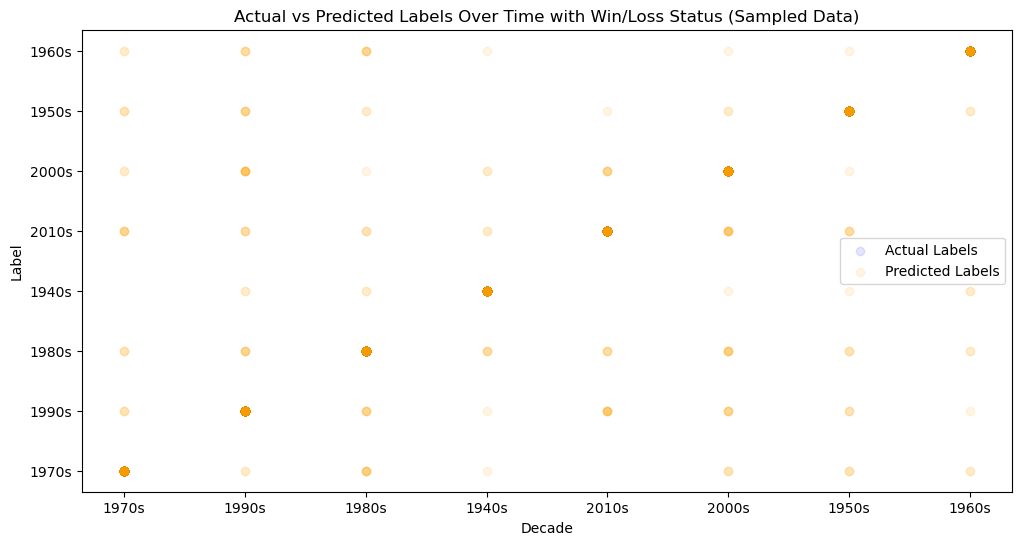

In [109]:
# Sample a subset of the data for faster plotting
sample_size = 1000  # Adjust the sample size as needed
sampled_data = year_pred_df.sample(sample_size, random_state=42)

# Plotting
plt.figure(figsize=(12, 6))

# Plotting actual labels
plt.scatter(sampled_data['decade'], sampled_data['decade'], label='Actual Labels', alpha=0.1, color='blue')

# Plotting predicted labels
plt.scatter(sampled_data['decade'], sampled_data['logreg_decade_pred'], label='Predicted Labels', alpha=0.1, color='orange')

# # Highlight win/loss status
# for i, win_loss in enumerate(sampled_data['win_loss']):
#     color = 'green' if win_loss == 1 else 'red'
#     plt.scatter(sampled_data['decade'].iloc[i], sampled_data['decade'].iloc[i],
#                 label=None, alpha=0.7, color=color, marker='x' if win_loss == 1 else 'o')

plt.title('Actual vs Predicted Labels Over Time with Win/Loss Status (Sampled Data)')
plt.xlabel('Decade')
plt.ylabel('Label')
plt.legend()
plt.show()

# 6. Sentiment Analysis over the decades

For this analysis, we will be looking into the different sentiments within the decades, but also within the winners and losers of our dataset. 

In [57]:
#decades 
# twenties = movie_subtitles_df[(movie_subtitles_df['Year'] >= '1920') & (movie_subtitles_df['Year'] < '1930')]
# thirties = movie_subtitles_df[(movie_subtitles_df['Year'] >= '1930') & (movie_subtitles_df['Year'] < '1940')]
forties = movie_subtitles_df[(movie_subtitles_df['years'] >= '1940') & (movie_subtitles_df['years'] < '1950')]
fifties = movie_subtitles_df[(movie_subtitles_df['years'] >= '1950') & (movie_subtitles_df['years'] < '1960')]
sixties = movie_subtitles_df[(movie_subtitles_df['years'] >= '1960') & (movie_subtitles_df['years'] < '1970')]
seventies = movie_subtitles_df[(movie_subtitles_df['years'] >= '1970') & (movie_subtitles_df['years'] < '1980')]
eighties = movie_subtitles_df[(movie_subtitles_df['years'] >= '1980') & (movie_subtitles_df['years'] < '1990')]
ninties = movie_subtitles_df[(movie_subtitles_df['years'] >= '1990') & (movie_subtitles_df['years'] < '2000')]
twenty = movie_subtitles_df[(movie_subtitles_df['years'] >= '2000') & (movie_subtitles_df['years'] < '2010')]
twenty_ten = movie_subtitles_df[(movie_subtitles_df['years'] >= '2010') & (movie_subtitles_df['years'] < '2020')]

In [58]:
years = [forties, fifties, sixties, seventies, eighties, ninties, twenty, twenty_ten]

In [59]:
forties.head(1)

,name,text,years,Movie Name,Similarity Calc Name,Win or Loss,tokenized_text,num_tokens
231,Foreign.Correspondent.1940.1080p.BluRay.x265-R...,\nWhat's new? \n- Same old daily bunkeroo. \n\...,1940,Foreign Correspondent,Foreign Correspondent,0.0,"[What, 's, new, ?, -, Same, old, daily, bunker...",17288


In [60]:
def sentiment_score(vader, text_string, name):
    sentiment_dict = vader.polarity_scores(text_string)
    overall_sentiment = 'positive' if sentiment_dict['compound'] >= 0.05 else 'negative' if sentiment_dict['compound'] <= -0.05 else 'neutral'
    # print("Movie:",name)
    # print("neg:      ",sentiment_dict['neg'])
    # print("neu:      ",sentiment_dict['neu'])
    # print("post:      ",sentiment_dict['pos'])
    # print("comp:      ",sentiment_dict['compound'])
    # print("overall sentiment: ", overall_sentiment)
    return sentiment_dict['pos'], sentiment_dict['neg']

In [61]:
#compiling sentiment scores for decades 
names = [1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010]
ind = 0
# pos_list, neg_list = [], []
pos_neg = {}
for year in years:
    analyzer = SentimentIntensityAnalyzer()
    pos_list, neg_list = [], []
    for text,movie in zip(year['text'], year['Movie Name']):
        pos, neg = sentiment_score(analyzer, str(text), movie)
        pos_list.append(pos)
        neg_list.append(neg)
    pos_neg[f"{names[ind]}_pos"] = pos_list
    pos_neg[f"{names[ind]}_neg"] = neg_list
    ind += 1

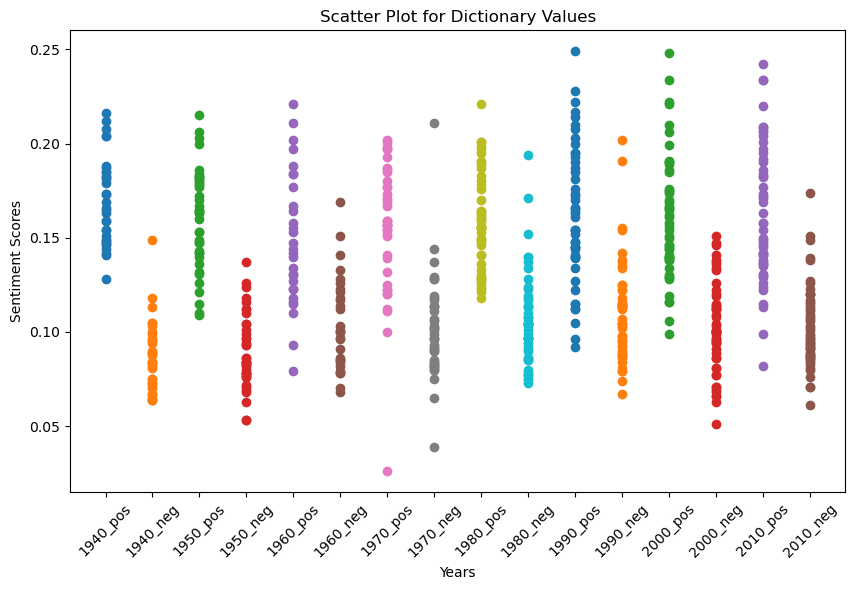

In [62]:
plt.figure(figsize=(10, 6))
plt.title('Scatter Plot for Dictionary Values')
plt.xticks(rotation=45)
plt.xlabel('Years')
plt.ylabel('Sentiment Scores')

for key, values in pos_neg.items():
    plt.scatter([key] * len(values), values, label=key)

plt.show()

In [63]:
#winners or losers 
winners = movie_subtitles_df[(movie_subtitles_df['Win or Loss'] == 1)]
losers = movie_subtitles_df[(movie_subtitles_df['Win or Loss'] == 0)]

In [64]:
names = ['wins', 'losses']
ind = 0
# pos_list, neg_list = [], []
win_loss = {}
for group in [winners, losers]:
    analyzer = SentimentIntensityAnalyzer()
    pos_list, neg_list = [], []
    for text, movie in zip(group['text'], group['Movie Name']):
        pos, neg = sentiment_score(analyzer, str(text), movie)
        pos_list.append(pos)
        neg_list.append(neg)
    win_loss[f"{names[ind]}_pos"] = pos_list
    win_loss[f"{names[ind]}_neg"] = neg_list
    ind += 1

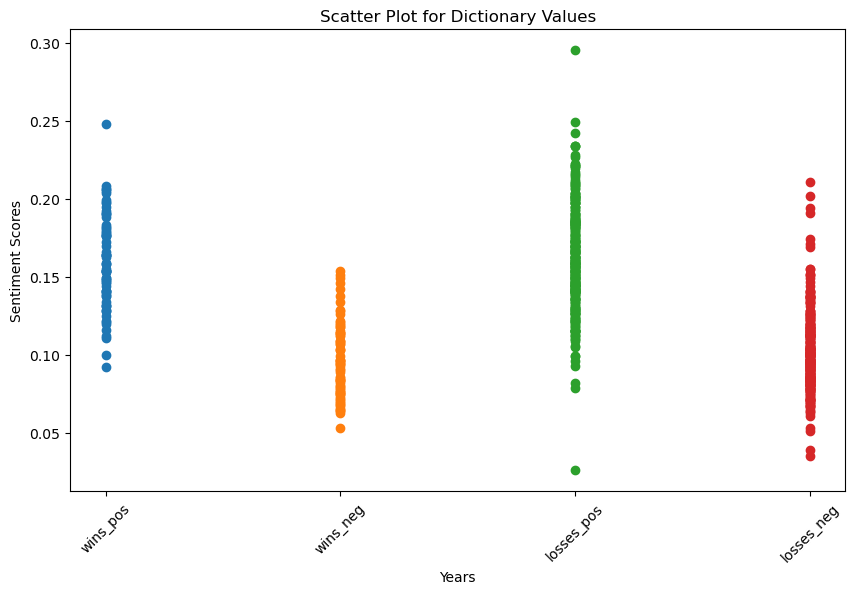

In [65]:
plt.figure(figsize=(10, 6))
plt.title('Scatter Plot for Dictionary Values')
plt.xticks(rotation=45)
plt.xlabel('Years')
plt.ylabel('Sentiment Scores')
for key, values in win_loss.items():
    plt.scatter([key] * len(values), values, label=key)

plt.show()

Now, we will perform the same analysis but using HuggingFace Library Instead. 

In [66]:
def sentiment_scores(text):
    model_name = "distilbert-base-uncased-finetuned-sst-2-english"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    classifier = pipeline("sentiment-analysis", model=model_name, tokenizer=tokenizer)
    shortened_text = text[2000:2512]
    results = classifier(shortened_text)
    
    positive_score = 0
    negative_score = 0

    for result in results:
        label = result['label'].lower()
        if label == 'positive':
            positive_score += result['score']
        elif label == 'negative':
            negative_score += result['score']

    return positive_score, negative_score

In [67]:
names = [1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010]
pos_neg = {}
ind = 0
for year in years:
    pos_list, neg_list = [], []
    
    for text, movie in zip(year['text'], year['Movie Name']):
        pos_score, neg_score = sentiment_scores(str(text))
        pos_list.append(pos_score)
        neg_list.append(neg_score)

    pos_neg[f"{names[ind]}_pos"] = pos_list
    pos_neg[f"{names[ind]}_neg"] = neg_list
    ind += 1

Xformers is not installed correctly. If you want to use memorry_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


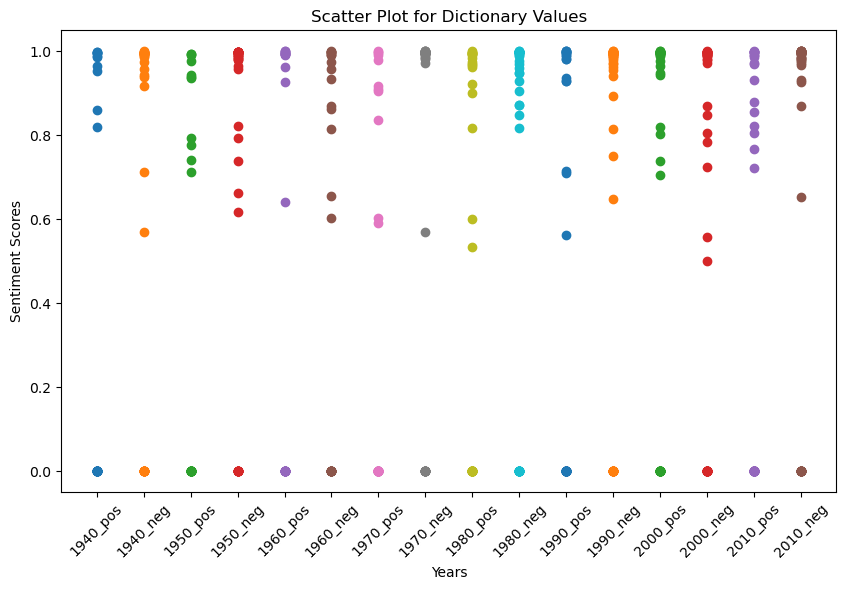

In [68]:
plt.figure(figsize=(10, 6))
plt.title('Scatter Plot for Dictionary Values')
plt.xticks(rotation=45)
plt.xlabel('Years')
plt.ylabel('Sentiment Scores')

for key, values in pos_neg.items():
    plt.scatter([key] * len(values), values, label=key)

plt.show()

In [69]:
names = ['wins', 'losses']
win_loss = {}
ind = 0
for group in [winners, losers]:
    pos_list, neg_list = [], []
    
    for text, movie in zip(group['text'], group['Movie Name']):
        pos_score, neg_score = sentiment_scores(str(text))
        pos_list.append(pos_score)
        neg_list.append(neg_score)

    win_loss[f"{names[ind]}_pos"] = pos_list
    win_loss[f"{names[ind]}_neg"] = neg_list
    ind += 1

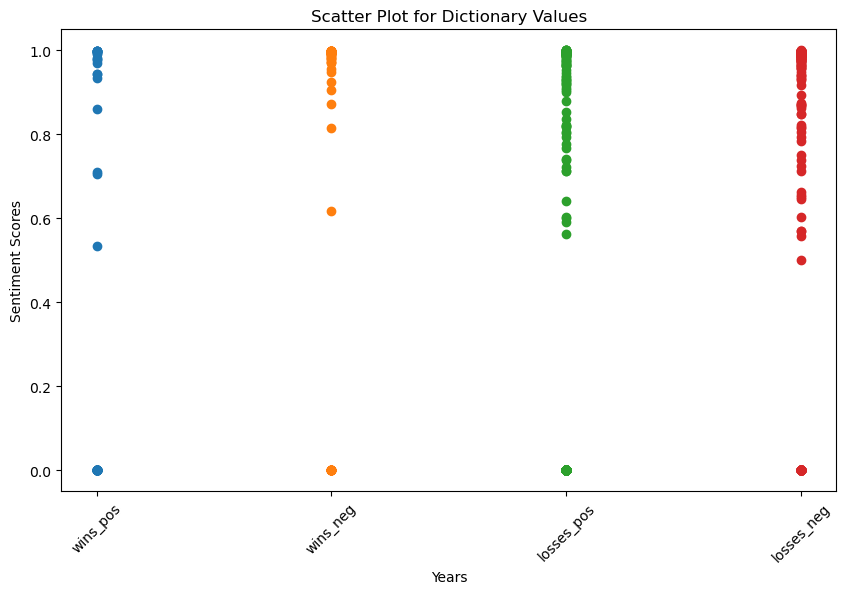

In [70]:
plt.figure(figsize=(10, 6))
plt.title('Scatter Plot for Dictionary Values')
plt.xticks(rotation=45)
plt.xlabel('Years')
plt.ylabel('Sentiment Scores')
for key, values in win_loss.items():
    plt.scatter([key] * len(values), values, label=key)

plt.show()